In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp


In [2]:
df = pl.read_parquet(
    "https://osf.io/gk2ty/download",
    use_pyarrow=True,
)


In [3]:
print(df.columns)


['Task', 'Treatment', 'Genome Length', 'Lineage Generation Index', 'Run ID', 'Is Task Coding Site', 'Is Viability Site', 'Is Task Coding Site Cumulative Count', 'Is Viability Site Cumulative Count', 'Prev Is Task Coding Site Cumulative Count', 'Prev Is Viability Site Cumulative Count', 'Prev Is Task Coding Site', 'Prev Is Viability Site', 'Site', 'Has Task', 'has task', 'delta has task', 'Delta Has Task', 'CHILD_SOURCE_MAP', 'POINT_MUTATION_BOOL_MASK', 'SLIP_INSERTION_ORIGIN_BOOL_MASK', 'SLIP_INSERTION_RESULT_BOOL_MASK', 'GENOME_CHARACTERS', 'Is Task Coding Site Delta', 'Is Viability Site Delta', 'Point Mutation Cumulative Count', 'Slip Insertion Cumulative Count', 'Prev Slip Insertion Cumulative Count', 'SLIP_INSERTION_BOOL_MASK', 'Generation Born', 'Update Born']


In [4]:
df = df.with_columns(
    pl.col("SLIP_INSERTION_BOOL_MASK").any().over(
        ["Treatment", "Run ID", "Generation Born"],
    ).alias("SLIP_INSERTION_BOOL_MASK any"),
)


In [5]:
df = df.with_columns(
    pl.col("Is Task Coding Site").any().over(
        ["Treatment", "Run ID", "Generation Born", "Site"],
    )
    .alias("is any coding site"),
)


In [6]:
df = df.with_columns(
    pl.col("Is Task Coding Site Delta").sum().over(
        ["Treatment", "Run ID", "Generation Born"],
    )
    .alias("is task coding site delta sum"),
)


In [7]:
df = df.with_columns(
    pl.col("has task").sum().over(
        ["Treatment", "Run ID", "Generation Born", "Site"],
    )
    .alias("num tasks has"),
)


In [8]:
df = df.with_columns(
    pl.col("is any coding site").sum().over(
        ["Treatment", "Run ID", "Generation Born", "Task",],
    ).alias("num coding sites"),
)


In [9]:
dfx = df.group_by(
    ["Treatment", "Run ID", "Generation Born"],
).first()


In [10]:
dfx = dfx.with_columns(
    (
        pl.col("num coding sites") / pl.col("Genome Length")
    ).alias("frac coding sites")
)


In [11]:
dfx


Treatment,Run ID,Generation Born,Task,Genome Length,Lineage Generation Index,Is Task Coding Site,Is Viability Site,Is Task Coding Site Cumulative Count,Is Viability Site Cumulative Count,Prev Is Task Coding Site Cumulative Count,Prev Is Viability Site Cumulative Count,Prev Is Task Coding Site,Prev Is Viability Site,Site,Has Task,has task,delta has task,Delta Has Task,CHILD_SOURCE_MAP,POINT_MUTATION_BOOL_MASK,SLIP_INSERTION_ORIGIN_BOOL_MASK,SLIP_INSERTION_RESULT_BOOL_MASK,GENOME_CHARACTERS,Is Task Coding Site Delta,Is Viability Site Delta,Point Mutation Cumulative Count,Slip Insertion Cumulative Count,Prev Slip Insertion Cumulative Count,SLIP_INSERTION_BOOL_MASK,Update Born,SLIP_INSERTION_BOOL_MASK any,is any coding site,is task coding site delta sum,num tasks has,num coding sites,frac coding sites
cat,cat,u16,cat,i64,u16,bool,bool,i16,i16,i16,i16,bool,bool,u16,bool,bool,i8,i8,i16,bool,bool,bool,cat,i8,i8,u16,u16,u16,bool,i32,bool,bool,i64,u32,u32,f64
"""Slip-duplicate""","""run_1614""",84,"""AND""",269,12,false,true,0,13,0,12,false,true,0,false,false,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,1079,false,false,0,0,0,0.0
"""Slip-duplicate""","""run_1615""",789,"""AND""",562,134,false,true,0,135,0,134,false,true,0,true,true,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,22704,false,false,0,6,88,0.156584
"""Slip-duplicate""","""run_1592""",999,"""AND""",592,167,false,true,0,168,0,167,false,true,0,true,false,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,26974,false,false,0,3,40,0.067568
"""Baseline-Treatment""","""run_1544""",2951,"""AND""",100,137,false,true,0,138,0,137,false,true,0,false,false,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,29090,false,false,0,6,33,0.33
"""Slip-duplicate""","""run_1591""",1027,"""AND""",554,188,false,true,0,189,0,188,false,true,0,true,true,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,37471,false,false,0,9,98,0.176895
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Slip-duplicate""","""run_1611""",1052,"""AND""",762,203,false,true,0,204,0,203,false,true,0,true,true,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,37962,false,false,-4,9,93,0.122047
"""Long-Ancestor-Control-Treatmen…","""run_1761""",270,"""AND""",1000,84,false,true,0,85,0,84,false,true,0,true,true,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,18995,false,false,0,5,59,0.059
"""Slip-duplicate""","""run_1590""",970,"""AND""",440,208,false,true,0,209,0,208,false,true,0,true,true,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,36973,false,false,0,9,76,0.172727


teeplots/errorbar=se+hue=treatment+post=plt-xscale-log+viz=lineplot+x=generation-born+y=num-coding-sites+ext=.pdf


teeplots/errorbar=se+hue=treatment+post=plt-xscale-log+viz=lineplot+x=generation-born+y=num-coding-sites+ext=.png


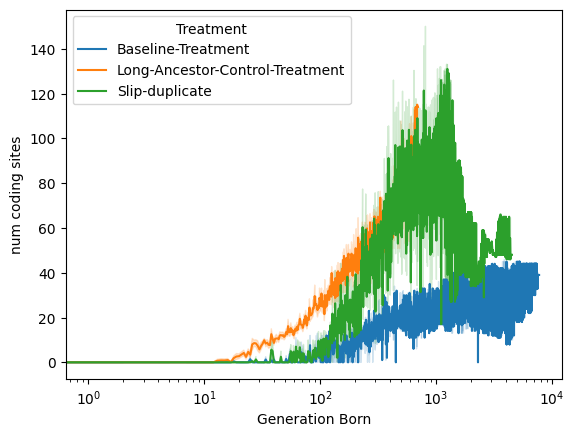

<Axes: xlabel='Generation Born', ylabel='num coding sites'>

In [12]:
tp.tee(
    sns.lineplot,
    hue="Treatment",
    y="num coding sites",
    x="Generation Born",
    data=dfx.to_pandas(),
    errorbar="se",
    teeplot_postprocess="plt.xscale('log')",
)


teeplots/errorbar=se+hue=treatment+post=plt-xscale-log+viz=lineplot+x=generation-born+y=frac-coding-sites+ext=.pdf


teeplots/errorbar=se+hue=treatment+post=plt-xscale-log+viz=lineplot+x=generation-born+y=frac-coding-sites+ext=.png


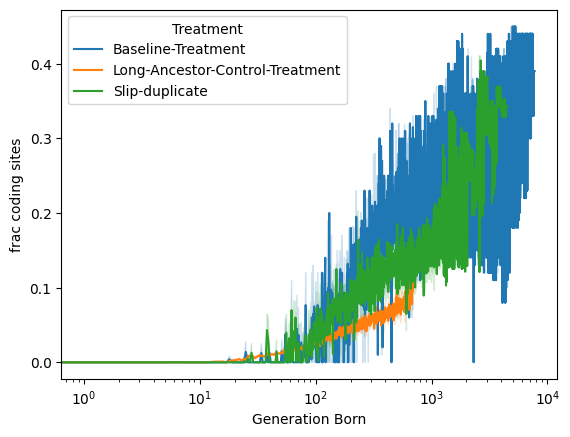

<Axes: xlabel='Generation Born', ylabel='frac coding sites'>

In [13]:
tp.tee(
    sns.lineplot,
    hue="Treatment",
    y="frac coding sites",
    x="Generation Born",
    data=dfx.to_pandas(),
    errorbar="se",
    teeplot_postprocess="plt.xscale('log')",
)
